# **ColoscoVision(Détection intelligente des varices Œsophagiennes)**

L'ensemble de données de notre data se compose de 4 000 images annotées du tractus gastro-intestinal réparties en 8 classes différentes (différentes anomalies), chaque classe contenant 500 images.

## **Importation de bibliothèques**

In [32]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import os

from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout


#### **Suppression du modèle enregistré**

Le modèle a été sauvegardé pour une utilisation future car son entraînement prend du temps. Il peut être supprimé pour reprendre l'entraînement à zéro.

Demande de suppression :

- Y/y : supprime le modèle
- Tout autre personnage : utilise l'ancien modèle


In [2]:
if os.path.isdir("./saved_model"):
    try:
        strr= input('delete saved model? Y/N')
        if strr == 'Y' or strr == 'y':
            !rm -rf "./saved_model"
            print("deleted model")
        else:
            print('the old model will be used')
    except:
        
        pass

delete saved model? Y/Ny
deleted model


'rm' is not recognized as an internal or external command,
operable program or batch file.


## **1. Configuration du dataset**

In [45]:
import os
os.path.isdir("../input") and os.path.isdir("/kaggle/working")
dataset_dir = "E:/ancien pc/3DNI/IA/archive/kvasir-dataset"
Labels = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']

### **1.2.Définir les catégories du DATA**


In [4]:
def get_dataCategories(dataset_dir):
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])


categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df


number of categories:  8


,categorie,numbre of files
0,dyed-lifted-polyps,500
1,dyed-resection-margins,500
2,esophagitis,500
3,normal-cecum,500
4,normal-pylorus,500
5,normal-z-line,500
6,polyps,500
7,ulcerative-colitis,500


### **1.3. Créer the set of features X ainsi que les labels y**
Pour ce faire, on lit chaque image du DATA et on la met dans X, et on sauvegarde la classe de l'image lue dans y.




In [5]:
def create_dataset(datadir, categories, img_wid, img_high):
    
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(X).reshape(y.shape[0], img_wid, img_wid, 3)
    return X, y


img_wid, img_high = 100, 100
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")


X: (4000, 100, 100, 3)
y: (4000,)


### **1.4. Affichage aléatoire des images pour chaque catégorie**


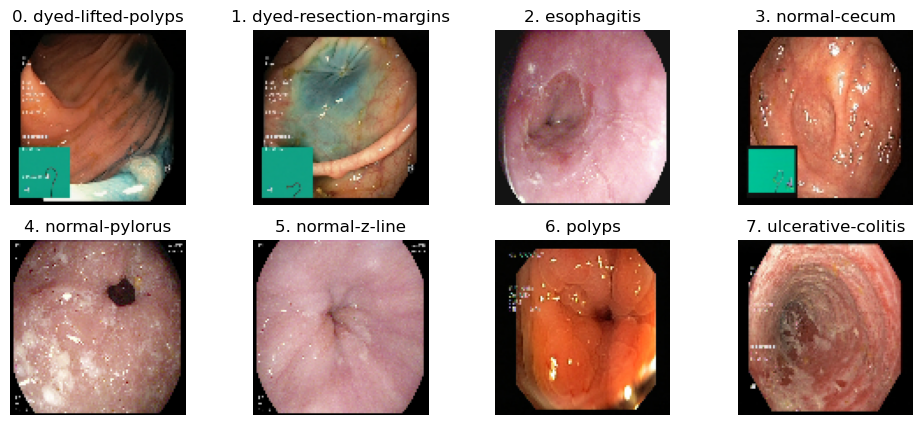

In [6]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    # plt.imshow(X[idx][:,:,::-1])
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()


## **2. Model Creation and Training**

### **2.1. La création de train, test and validation set**

Dans cette étape, nous créons :

-the `x_train/y_train` training set

-the `x_test/y_test test` set

-the validation set `x_val/y_val`

#### **2.1.1. La création de train and test set**
Les données sont réparties entre 80 % et 20 % pour training and testing.

In [7]:
# Converting y to scaler format
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"t_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


X_train: (3200, 100, 100, 3)
t_train: (3200, 1)
X_test: (800, 100, 100, 3)
y_test: (800, 1)


#### **2.1.2. La  création de validation set `x_val/y_val`**


On divise 30 % de training en validation set

x_train.shape  donne la dimension de l'ensemble de training .

In [8]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
x_test = X_test

# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")


x_train:(2240, 100, 100, 3),  y_train:(2240, 1)
x_train:(960, 100, 100, 3),  y_train:(960, 1)
x_train:(800, 100, 100, 3),  y_train:(800, 1)


#### **2.1.3. OneHot Encoding the Prediction**

Nous devons faire un OneHot Encoding avec to_categorical, pour transformer toutes les labels (y_train, y_val et y_test) afin que nous ayons un vecteur pour chaque exemple, car nous avons 8 classes et nous devons nous attendre à quelle forme (y_train, y_val et y_test) passe de 1 à 8

In [9]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2240, 100, 100, 3),  y_train:(2240, 8)
x_train:(960, 100, 100, 3),  y_train:(960, 8)
x_train:(800, 100, 100, 3),  y_train:(800, 8)


### **2.2. Generation of images**

Ici, nous allons effectuer l'augmentation des données d'image. La technique utilisée pour augmenter la taille d'un ensemble de données d'entraînement en créant des versions modifiées des images dans l'ensemble de données. La création de ces images modifiées se fait en faisant pivoter ces images de manière aléatoire de n'importe quel degré entre 0 et 360.

Tout d’abord, nous définirons des instances ImageDataGenerator individuelles pour l’augmentation, puis nous les adapterons à chacun des ensembles de données de training, de test et de validation.

In [10]:
# Image Data Augmentation
train_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

val_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

test_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)


### **2.3. Downloading the VGG19 pre-trained model**

Nous allons maintenant instancier le modèle « VGG19 » qui est un réseau neuronal convolutionnel pre-trained comme  transfer learning mode.

Le plus grand avantage de ce réseau est qu'il a été pre-trained sur plus d'un million d'images de la base de données ImageNet.

Un réseau pre-trained peut classer les images en milliers de catégories d'objets. En raison de cet avantage, nous appliquerons ce modèle à notre ensemble de données qui comporte 8 catégories, en y ajoutant d'autres couches.


In [11]:
# if it has already been created and saved --> read the model
if os.path.isfile("./saved_model/vgg19_model.h5"):
    # load model
    base_model = load_model("./saved_model/vgg19_model.h5")
    
# if it has not already been created --> create the model and save it
else:
    base_model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=y_train.shape[1],
    )
    # save model
    base_model.save("./saved_model/vgg19_model.h5")

on va definir `VGG19` comme a deep learning architecture. Pour cela, il sera défini comme un modèle a sequential model of Keras with several dense layers.

In [12]:
#Utilisant Keras on a créé un modèle séquentiel
model = Sequential()
#Ajouter Layer basée sur un modèle pre-trained
model.add(base_model)
model.add(Flatten())

Maintenant, pour ajouter plus Layers, nous devons voir la dimension de notre modèle.

In [13]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 20024384 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Ajouter dense layers avec batch activation and normalization.

In [14]:
model.add(Dense(1024, activation=("relu"), input_dim=512))
model.add(Dense(512, activation=("relu")))
model.add(Dense(256, activation=("relu")))
model.add(Dropout(0.3))
model.add(Dense(128, activation=("relu")))
# model.add(Dropout(.2))
model.add(Dense(y_train.shape[1], activation=("softmax")))

La vérification du model finale

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

### **2.4. Hyperparameter Tuning**

Hyperparameters sont des paramètres réglables qui nous permettent de contrôler le processus de formation du modèle. Les performances du modèle dépendent fortement des Hyperparameters.

Comme nous avons défini notre modèle, nous devons maintenant initialiser les hyperparamètres nécessaires pour entraîner le modèle, puis enfin, nous compilerons notre modèle.

In [16]:
""" Initializing the hyperparameters """

# Initialise no. of training samples for each batch
batch_size = 128

# No. of iterations
epochs = 100

# Learning rate
learn_rate = 0.001

# Using Gradient Descent
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

# Using adam optimizer
# adam = Adam( learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compiling the model
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])


La réduction Learning rate diminue the learning rate après un certain nombre d'itérations si le taux d'erreur ne change pas. Ici, grâce à cette technique, nous surveillerons la précision de la validation et si elle cesse de s'améliorer nous réduirons the learning rate de 0,01.

In [17]:
# Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor="val_acc", factor=0.01, patience=3, min_lr=1e-5)

### **2.5. Training the model**

On commence training notre model.

In [18]:
# if model has already been trained and saved ---> read the model
if os.path.isfile("./saved_model/model.h5"):

    # Load model
    model = load_model("./saved_model/model.h5")

    # if model history has been saved --> read history
    if os.path.isfile("./saved_model/model_history.npy"):

        # Read history
        history = np.load("./saved_model/model_history.npy", allow_pickle="TRUE").item()
    else:
        history = None

# if the model has not already been trained --> train the model
else:
    history = model.fit(
        # train_generator.flow(x_train, y_train, batch_size= batch_size),
        x_train,
        y_train,
        epochs=epochs,
        steps_per_epoch=x_train.shape[0] // batch_size,
        validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
#         validation_steps=250,
        callbacks=[lrr],
        verbose=1,
    )
    history = history.history

    # save model
    np.save("./saved_model/model_history.npy", history)
    model.save("./saved_model/model.h5")


## **3. Model Evaluation**

### **3.1. Evaluate accuracy on the test set**

Évaluer la précision ainsi que la perte du modèle sur l'ensemble de test

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", round(score[0], 3))
print("Test accuracy:", round(score[1], 3))

Test loss: 1.156
Test accuracy: 0.869


In [20]:
score

[1.1555447578430176, 0.8687499761581421]

In [21]:
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

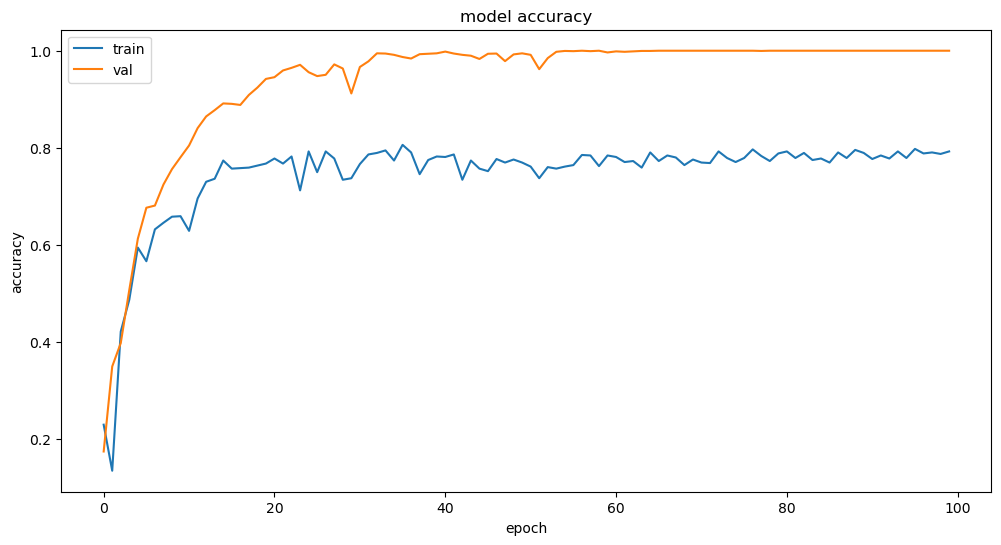

In [22]:
import matplotlib.pyplot as plt2
plt2.figure(figsize=(12, 6))
plt2.plot(history['val_accuracy'])
plt2.plot(history['accuracy'])
plt2.title('model accuracy')
plt2.ylabel('accuracy')
plt2.xlabel('epoch')
plt2.legend(['train', 'val'], loc='upper left')
plt2.show()

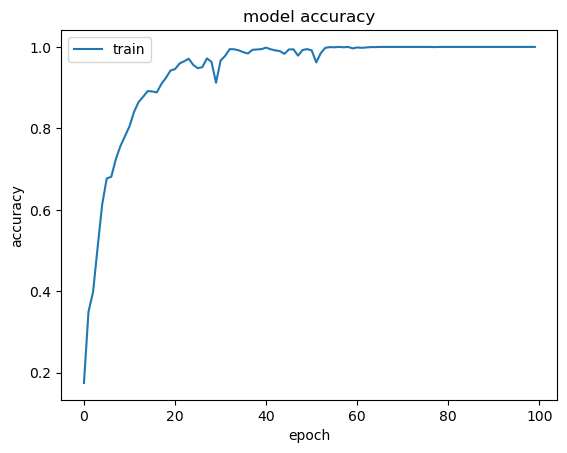

In [23]:
plt2.plot(history['accuracy'])
plt2.title('model accuracy')
plt2.ylabel('accuracy')
plt2.xlabel('epoch')
plt2.legend(['train', 'val'], loc='upper left')
plt2.show()

### **3.2. Confusion Matrix**

Enfin, nous visualiserons les performances de classification sur les données de test à l'aide confusion matrices.

In [24]:
def cm_plt(ax, cm, classes, cmap, title, normalize):
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax

# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

Prédire les classes de test

In [25]:
# Making the predictions
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

25/25 [==============================] - 44s 2s/step


Affiche la matrice de confusion normalisée et non normalisée.

Nous verrons le nombre exact de classifications correctes et incorrectes en utilisant la matrice de confusion non normalisée, puis nous verrons la même chose en pourcentage en utilisant la matrice de confusion normalisée.

Comme on peut le constater en classant les images en 8 classes, le modèle a donné une précision minimale de 79 % et une précision maximale de 97 %. Nous pouvons affiner davantage les paramètres d'entraînement et recycler notre modèle pour voir toute mise à l'échelle possible dans la classification.

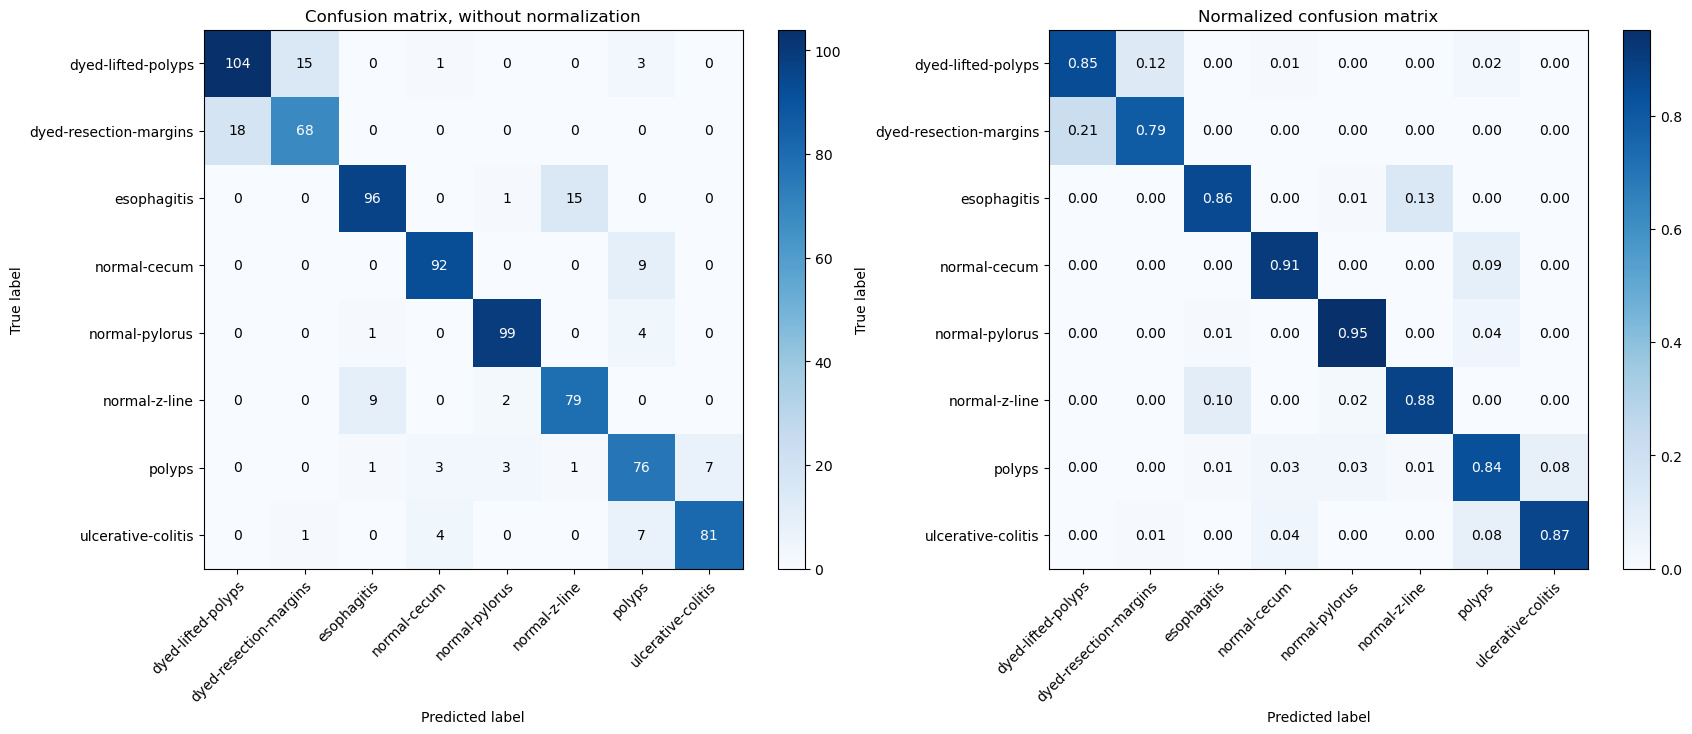

In [26]:
# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))


### **3.3. Random Predicion**

Prédir les images choisies au hasard et comparez-les

1/1 [==============================] - 0s 98ms/step


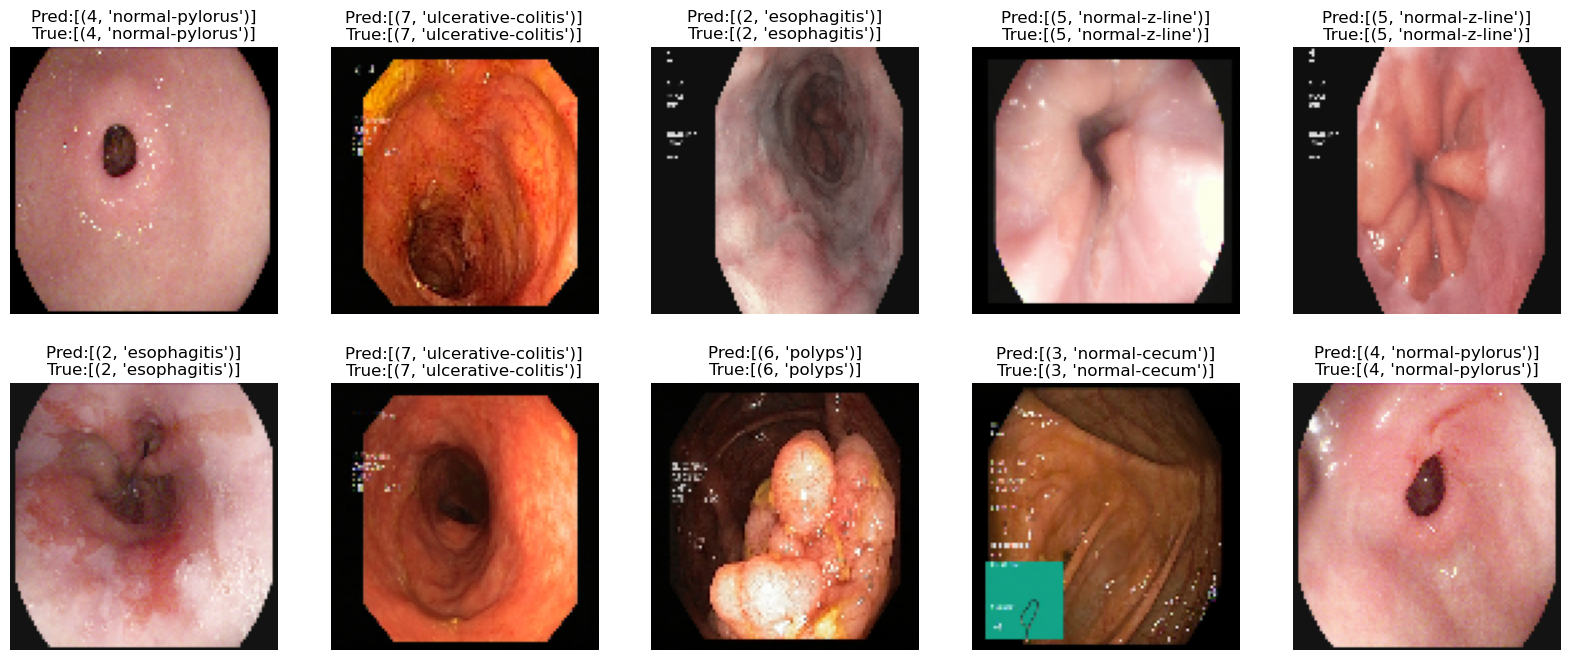

In [27]:
def predict_categorie_img(img, model, categories):
    try:
        img = img[None, :, :, :]
    except:
        raise TypeError("test image dimension != 3")
    predict = model.predict(img)
    idx_cat = np.argmax(predict, axis=1)[0]
    return idx_cat, categories[idx_cat]

plt.figure(figsize=(20, 8))
for i in range(10):
    idx = np.random.randint(len(y))
    img = X[idx]
    pred_class = predict_categorie_img(img, model, categories)
    true_class = y[idx], categories[y[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Pred:[{pred_class}]\nTrue:[{true_class}]")
    plt.axis("off")
plt.show()


Export as saved model and convert to TFLite:

In [30]:
import time
t = time.time()
export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)
export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1700046577\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1700046577\assets


'/tmp/saved_models/1700046577'

In [48]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {Labels[class_idx]: probabilities[class_idx]}

Transfer Learning with TensorFlow hub:

In [39]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

Data Preprocessing:

In [40]:

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.3)
  
train_generator = train_datagen.flow_from_directory(
    dataset_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 2800 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


1/1 [==============================] - 0s 57ms/step
class: normal-z-line, confidence: 0.266373


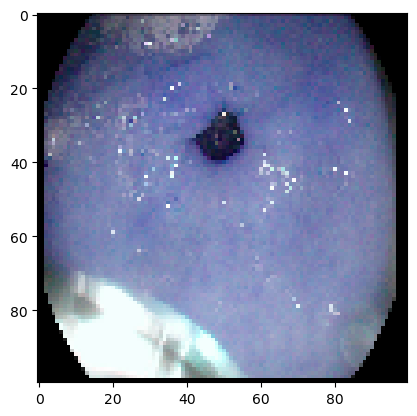

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 51ms/step
class: normal-z-line, confidence: 0.226257


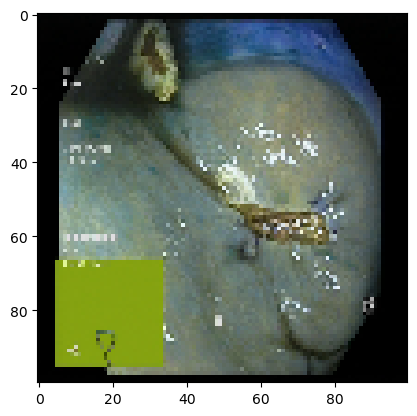

1/1 [==============================] - 0s 51ms/step
class: normal-z-line, confidence: 0.247088


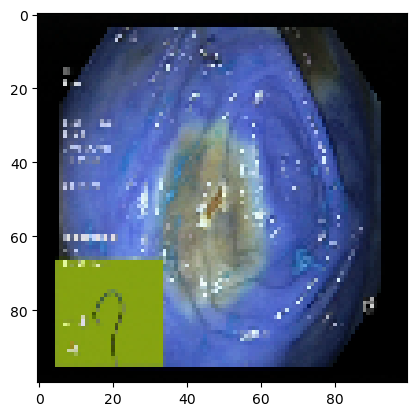

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 53ms/step
class: normal-z-line, confidence: 0.272147


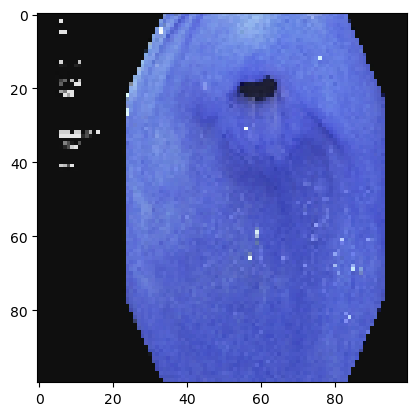

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 52ms/step
class: normal-z-line, confidence: 0.324970


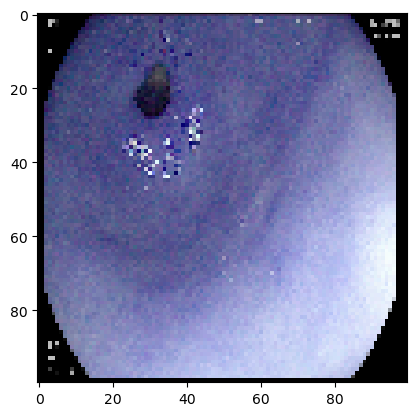

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 52ms/step
class: normal-z-line, confidence: 0.269333


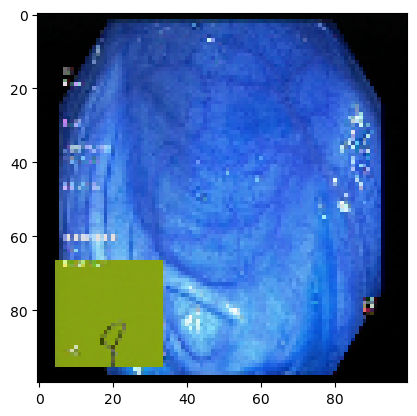

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 53ms/step
class: normal-z-line, confidence: 0.293520


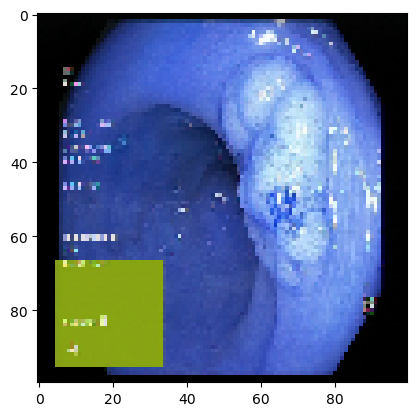

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 52ms/step
class: normal-z-line, confidence: 0.236411


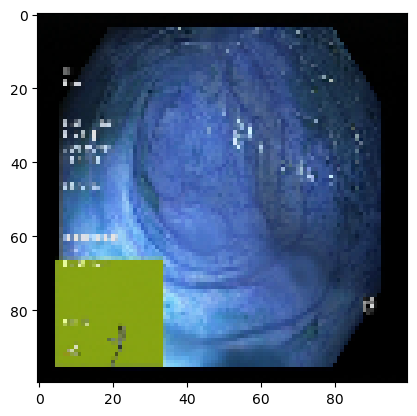

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 54ms/step
class: normal-z-line, confidence: 0.234782


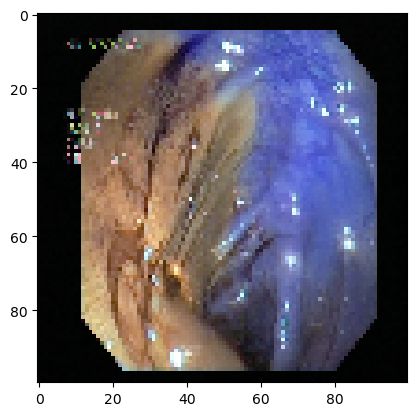

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 55ms/step
class: normal-z-line, confidence: 0.226633


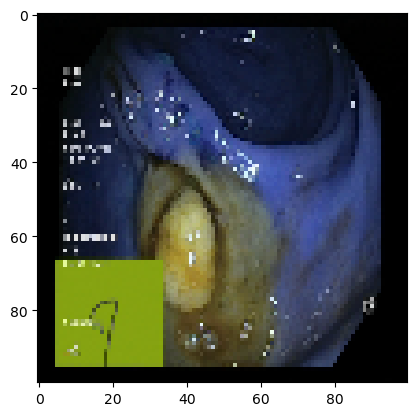

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 51ms/step
class: normal-z-line, confidence: 0.308228


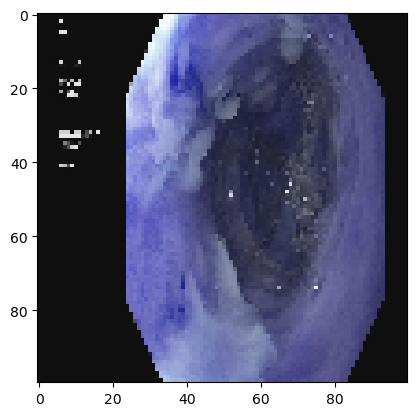

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 51ms/step
class: normal-z-line, confidence: 0.322595


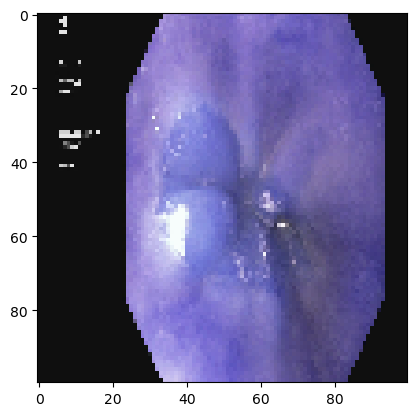

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 52ms/step
class: normal-z-line, confidence: 0.299156


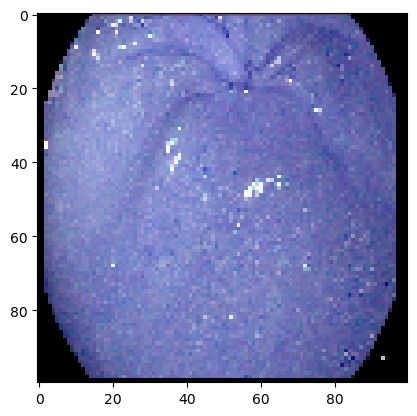

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 52ms/step
class: normal-z-line, confidence: 0.251893


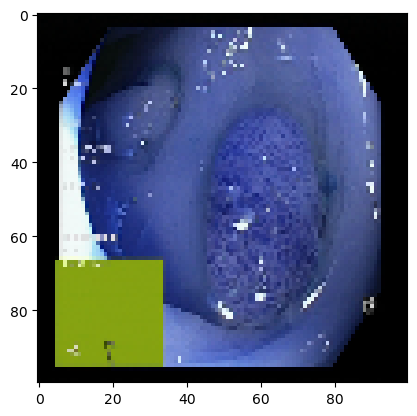

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 55ms/step
class: normal-z-line, confidence: 0.317147


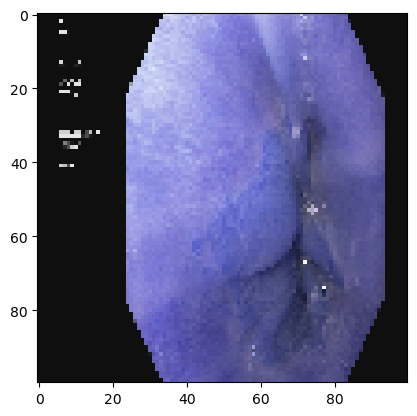

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 57ms/step
class: normal-z-line, confidence: 0.243856


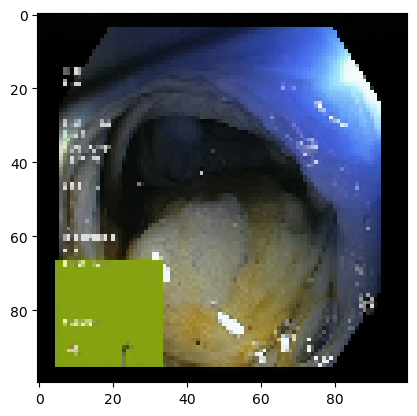

<Figure size 640x480 with 0 Axes>

In [46]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(dataset_dir, filename))
    img = cv2.resize(img, (100, 100) )
    img = img /255
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

SOURCE: class: dyed-lifted-polyps, file: dyed-lifted-polyps\361163c6-2be7-4c90-b507-26fc46e30cc1.jpg
1/1 [==============================] - 0s 207ms/step
PREDICTED: class: normal-z-line, confidence: 0.265107


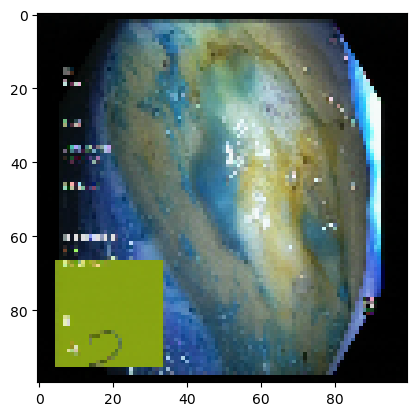

<Figure size 640x480 with 0 Axes>

SOURCE: class: normal-z-line, file: normal-z-line\01cf965e-28f2-4fc2-9d42-dace76989ca2.jpg
1/1 [==============================] - 0s 53ms/step
PREDICTED: class: normal-z-line, confidence: 0.315192


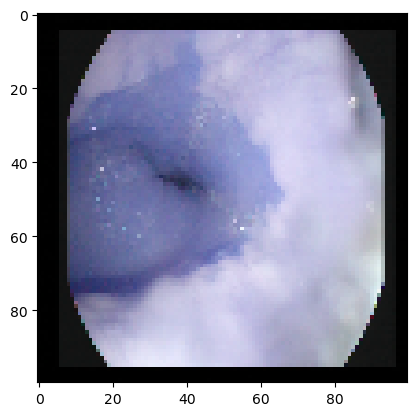

In [47]:
import random
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [50]:
# convert the model to TFLite
!mkdir "tflite_models3"
TFLITE_MODEL = "tflite_models3/model3.tflite"

# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

101749816